# Indian Ethnicity Classifier using Deep Learning
> "I trained the model with images of different ethnic people using BING API"

- toc: true
- branch: master
- badges: true
- comments: true
- categories: [fastpages, jupyter]
- image: images/UNI87429.jfif
- hide: false
- search_exclude: true
- metadata_key1: metadata_value1
- metadata_key2: metadata_value2

First we have to import the libraries needed for this project. <br/>
Here we are using fast AI which is based on Pytorch

> Note: Link to live app made with the help of binder [an example website: Indian ethnicity classifier](https://mybinder.org/v2/gh/bilalhaider10/ethnicity-indian.git/main?urlpath=%2Fvoila%2Frender%2Ffinal.ipynb).

## Importing Fast AI

In [3]:
#hide
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()


In [4]:
from fastbook import *
from fastai.vision.widgets import *

### Using Bing Api to download images
To download images with  **Bing Image Search** , sign up at Microsoft Azure for a free account. You will be given a key, which you can copy and enter in a cell as follows (replacing 'XXX' with your key and executing it):

In [5]:
key = os.environ.get('AZURE_SEARCH_KEY', 'XXX')

## We could use this function by providing maximum images to download and the end point of the API

In [6]:
 def search_images_bing(key, term, max_images: int = 100, **kwargs):    
     params = {'q':term, 'count':max_images}
     headers = {"Ocp-Apim-Subscription-Key":key}
     search_url = "https://api.bing.microsoft.com/v7.0/images/search"
     response = requests.get(search_url, headers=headers, params=params)
     response.raise_for_status()
     search_results = response.json()    
     return L(search_results['value'])
    

### As almost all indians are from these three ethnicities

In [7]:
ethnicGroups = 'indo-aryan','dravidian','indian mongloid'
path = Path('ethnicGroups')

### Now we are using Fast AI *download_images* function to download images to the path provided

In [9]:
if not path.exists():
    path.mkdir()
for o in ethnicGroups:
    dest = (path/o)
    dest.mkdir(exist_ok=True)
    results = search_images_bing(key, f'{o} people')
    download_images(dest, urls=results.attrgot('contentUrl'))


 Download of https://atlanblackhouse.files.wordpress.com/2016/07/nazis-greek-olympics-indo-aryan-people.png has failed after 5 retries
 Fix the download manually:
$ mkdir -p ethnicGroups/indo-aryan
$ cd ethnicGroups/indo-aryan
$ wget -c https://atlanblackhouse.files.wordpress.com/2016/07/nazis-greek-olympics-indo-aryan-people.png
$ tar xf nazis-greek-olympics-indo-aryan-people.png
 And re-run your code once the download is successful




 Download of https://blackhistory938.files.wordpress.com/2017/12/the-other_home-of-subcultures-and-style-documentary_india-masquerade-gods-yannick-cormier_14.jpg has failed after 5 retries
 Fix the download manually:
$ mkdir -p ethnicGroups/dravidian
$ cd ethnicGroups/dravidian
$ wget -c https://blackhistory938.files.wordpress.com/2017/12/the-other_home-of-subcultures-and-style-documentary_india-masquerade-gods-yannick-cormier_14.jpg
$ tar xf the-other_home-of-subcultures-and-style-documentary_india-masquerade-gods-yannick-cormier_14.jpg
 And re-run your code once the download is successful



### Now we check the images

In [10]:
fns = get_image_files(path)
fns

(#424) [Path('ethnicGroups/dravidian/00000000.jpg'),Path('ethnicGroups/dravidian/00000039.png'),Path('ethnicGroups/dravidian/00000001.jpg'),Path('ethnicGroups/dravidian/00000002.JPG'),Path('ethnicGroups/dravidian/00000002.jpg'),Path('ethnicGroups/dravidian/00000003.jpg'),Path('ethnicGroups/dravidian/00000004.jpg'),Path('ethnicGroups/dravidian/00000005.jpg'),Path('ethnicGroups/dravidian/00000006.jpg'),Path('ethnicGroups/dravidian/00000062.PNG')...]

### Now we have to check corrupt images

In [11]:
failed = verify_images(fns)
failed

(#3) [Path('ethnicGroups/dravidian/00000007.jpg'),Path('ethnicGroups/indian mongloid/00000071.jpg'),Path('ethnicGroups/indo-aryan/00000080.png')]

### Delete the images with unlink function

In [12]:
failed.map(Path.unlink);

### Now we have to make a dataloader.
# *DataLoader* : DataLoaders: A fastai class that stores multiple DataLoader objects you pass to it, normally a train and a valid, although it's possible to have as many as you like. The first two are made available as properties. 
[^1] Definition from Jeremy Book "Deep Learning for coders".

In [13]:
groups = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=45),
    get_y=parent_label,
    item_tfms=Resize(128))

In [14]:
dls = groups.dataloaders(path)

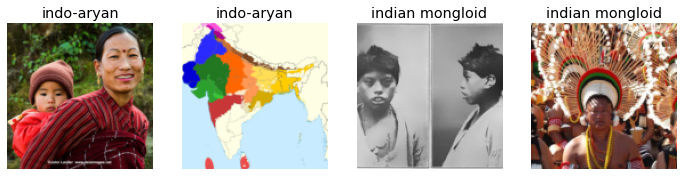

In [15]:
dls.valid.show_batch(max_n=4, nrows=1)

As we can see above the images are not correct so we have to clean our image dataset. If you could manually get some image dataset the result would be so much better.

We are using data augmentation for better accuracy. <br/> 
 **Data augmentation** refers to creating random variations of our input data, such that they appear different, but do not actually change the meaning of the data. Examples of common data augmentation techniques for images are rotation, flipping, perspective warping, brightness changes and contrast changes* <br/>
*[^1] Definition from Jeremy Book "Deep Learning for coders".*

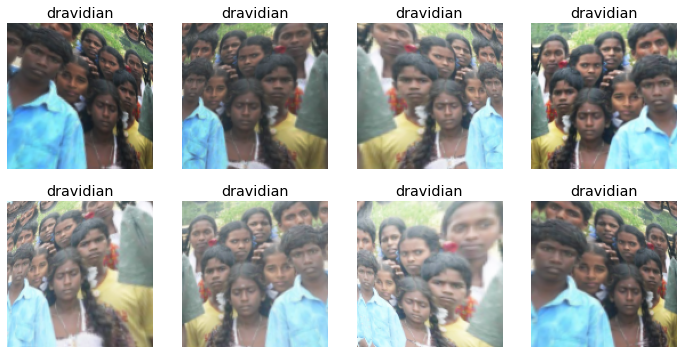

In [16]:
groups = groups.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = groups.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

Now using bigger size image for better result.

In [18]:
groups = groups.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = groups.dataloaders(path)

## Now using transfer learning technique in resnet18 architecture <br/> With fast AI we are using so much less lines of code.

In [19]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.708008,0.922546,0.357143,00:05


epoch,train_loss,valid_loss,error_rate,time
0,1.080864,0.907514,0.392857,00:06
1,0.966108,0.896233,0.333333,00:06
2,0.899231,0.951731,0.333333,00:06
3,0.833207,0.921495,0.321429,00:06


## The accuracy is not great the error rate is around 32 % but we will clean aur data and get better results

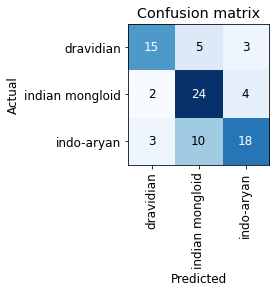

In [20]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

### These images are some of the examples of bad results.

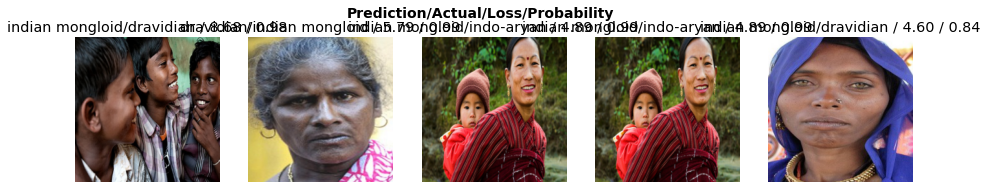

In [21]:
interp.plot_top_losses(5, nrows=1)

## *With the help of fast AI functions we would clean our dataset*

In [22]:
cleaner = ImageClassifierCleaner(learn)
cleaner

In [28]:
for idx in cleaner.delete(): cleaner.fns[idx].unlink()
for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

## Now we will re train our model with new dataset.

In [29]:
groups = groups.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = groups.dataloaders(path)

## As we could see our accuracy has very much increased and error rate is dropped to 23%

In [30]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.801849,2.149620,0.526316,00:04


epoch,train_loss,valid_loss,error_rate,time
0,1.326655,1.366351,0.473684,00:05
1,1.124967,0.936145,0.302632,00:05
2,0.983991,0.811113,0.236842,00:05
3,0.864988,0.783508,0.236842,00:05


## Now we export our model for use

In [31]:
learn.export()

In [32]:
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

In [33]:
learn_inf = load_learner(path/'export.pkl')

## We will create a GUI for a small application to use this model on Notebook with the help of IPython widgets (ipywidgets) and Voilà

In [34]:
btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

In [36]:
img = PILImage.create(btn_upload.data[-1])

In [37]:
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(img.to_thumb(128,128))
out_pl

Output()

In [38]:
pred,pred_idx,probs = learn_inf.predict(img)

In [39]:
lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
lbl_pred

Label(value='Prediction: indo-aryan; Probability: 0.8998')

In [40]:
btn_run = widgets.Button(description='Classify')
btn_run

Button(description='Classify', style=ButtonStyle())

In [50]:
def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred,pred_idx,probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {100* probs[pred_idx]:.02f}%'

btn_run.on_click(on_click_classify)

In [51]:
#hide
#Putting back btn_upload to a widget for next cell
btn_upload = widgets.FileUpload()

## With the help of IPython widgets we made a simple gui to implement our result when we click on upload a box will appear to input image and when we press classify it prints our result

In [53]:
VBox([widgets.Label('Select image to check ethnicity!'), 
      btn_upload, btn_run, out_pl, lbl_pred])